# Handling Continuous Bosonic Baths with `pyttn.oqs`

### Contents

1. [Importing the Library](#importing-the-library)

2. [Continuous Bosonic Baths](#continuous-bosonic-baths)

    - [Bath Correlation Functions](#bath-correlation-functions)

3. [Discretise Baths](#discrete-baths)

4. [Sum-of-Exponential Baths](#sum-of-exponential-baths)

### Importing the Library

The first step of any pyTTN calculation is to import the Library.  For Open Quantum system calculations we will also want to import the `pyTTN.oqs` submodule as it provides several useful tools for easily setting up these calculations.


In [8]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

### Continuous Bosonic Baths

Now that we have imported the library we can begin setting up the OQS system information.  Here we will consider the case of a Gaussian bosonic bath, with a thermal Gaussian Initial configuration.  In such a case, the influence of the bath on the system dynamics is entirely encoded in the bath Spectral function

- At zero temperature, $S(\omega) = J(\omega) \quad \forall \, \omega > 0$

- At finite temperature, $S(\omega) = \frac{1}{2} J(\omega) \left( 1 + \frac{1}{\text{tanh}(\frac{\beta \omega}{2})} \right)$

where $J(\omega)$ is the bath spectral density, and encodes all information about the bath frequencies and coupling constants. In this example, we will consider a spectral density of the form:

$$
J(\omega) = \text{sign}(\omega) \frac{\pi}{2}\alpha\omega_c \left(\frac{\omega}{\omega_c}\right)^s e^{-|\omega/\omega_c|}
$$.

where $\alpha$ is the Kondo parameter, $\omega_c$ is the cutoff frequency, and $s$ controls the low-frequency dependence of the bath.  We start by defining the bath spectral density function:  

In [9]:
#set up the bath spectral density
alpha = 1.25
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)


Within pyTTN, the `pyttn.oqs.BosonicBath` class has been provided for handling the spectral function of bosonic baths at both zero and finite temperature, and importantly wraps many of the core operations we would want to perform on such an object, e.g
    - Computing the corresponding bath correlation function
    - Evaluating a discrete bath that efficiently represents the influence of the bath on the system dynamics
    - Performing a sum-of-exponentials fit of the bath correlation function for use with pseudomode/HEOM methods.

We may construct a zero temperature bath using:

In [10]:
#build the bosonic bath with temperature T=0
bath_zero_T = oqs.BosonicBath(J, beta=None)

Alternatively, we can create a finite temperature bath object by setting the inverse temperature $\beta=1/T$ as follows:

In [11]:
#build the bosonic bath with temperature T=1
T=1
bath_finite_T = oqs.BosonicBath(J, beta=1/T)

#### Bath Correlation Functions

We can now readily compute the bath correlation functions using these `pyttn.oqs.BosonicBath` objects giving:

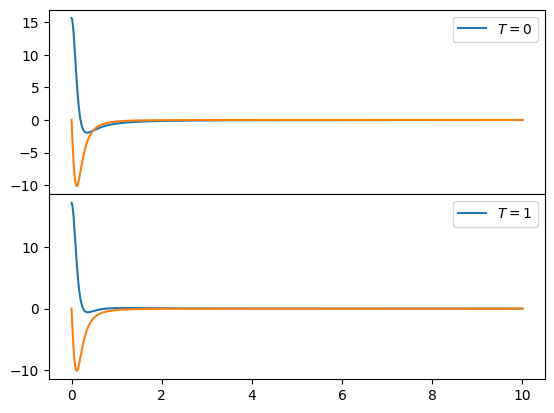

In [12]:
t = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), label=r"$T=0$")
ax[0].plot(t, np.imag(Ct0))

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1))

ax[0].legend()
ax[1].legend()

plt.show()

The `pyttn.oqs.BosonicBath` object also contains several functions for constructing alternative representations of the bath needed for unitary dynamics, and pseudomode/HEOM dynamics simulations.  


### Sum-of-Exponential Baths

For non-unitary dynamics methods (e.g. pseudomode and HEOM), an alternative representation of the bath is employed, namely a sum-of-exponential decomposition of the bath correlation function.  Within pyTTN, several methods have been provided for doing so, for details see the `pyttn.oqs.bath_fitting.expfit.py` for more details. Here, we will demonstrate the use of the ESPRIT method (`pyttn.oqs.ESPRITDecomposition`) for doing so:

In [13]:
#specify the time step information used in the ESPRIT fitting
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1    

#specify the number of terms in the sum-of-exponential fit
K=2

#fit the zero and finite temperature baths
dk0, zk0 = bath_zero_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))
dk1, zk1 = bath_finite_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

Here we have performed the sum-of-exponential fit for the two baths, obtaining coefficient constants $dk$ and decay rates $zk$ for each bath, using a total of $K=2$ terms in the decomposition.  As in the unitary case, there are still a few steps needed inorder to use these coefficient in a simulation.

 To help simplify this process, pyTTN includes the `pyttn.oqs.ExpFitBosonicBath` class that provides a set of function to significantly simplify each of the process of setting up dynamics simulations.  These steps will be explored in more detail below.  Here we will just set up a ExpFit bath object and use it to plot the discrete bath correlation function.

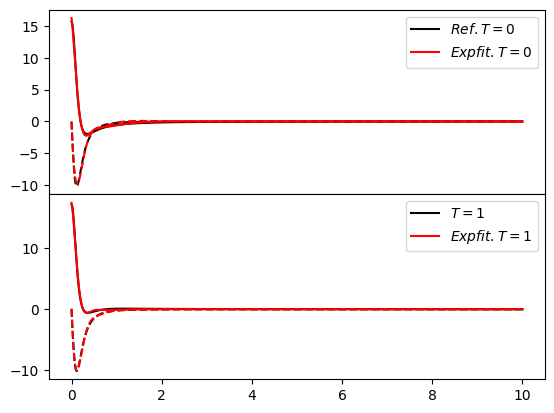

In [14]:
expfit_bath_zero_T = oqs.ExpFitBosonicBath(dk0, zk0)
expfit_bath_finite_T = oqs.ExpFitBosonicBath(dk1, zk1)

Ctd0 = expfit_bath_zero_T.Ct(t)
Ctd1 = expfit_bath_finite_T.Ct(t)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

#plot the bath correlation functions
Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), 'k', label=r"$Ref. T=0$")
ax[0].plot(t, np.imag(Ct0), 'k--')
ax[0].plot(t, np.real(Ctd0), 'r', label=r"$Expfit. T=0$")
ax[0].plot(t, np.imag(Ctd0), 'r--')

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), 'k', label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1), 'k--')
ax[1].plot(t, np.real(Ctd1), 'r', label=r"$Expfit. T=1$")
ax[1].plot(t, np.imag(Ctd1), 'r--')

ax[0].legend()
ax[1].legend()

plt.show()

Even with $K=2$ bath modes we observe qualitatively reasonable fits for the bath correlation function.  Looking at short time we see deviation froms the exact and fit correlation functions.

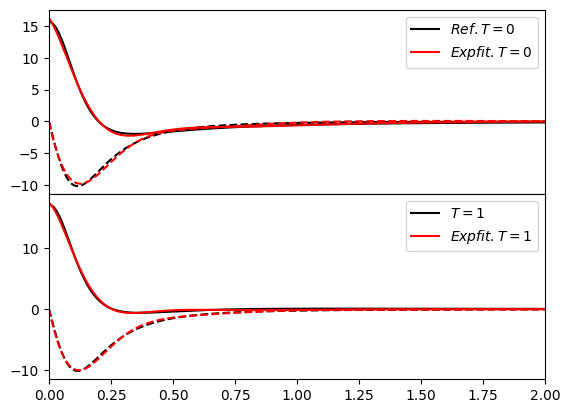

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

ax[0].set_xlim([0, 2])

#plot the bath correlation functions
ax[0].plot(t, np.real(Ct0), 'k', label=r"$Ref. T=0$")
ax[0].plot(t, np.imag(Ct0), 'k--')
ax[0].plot(t, np.real(Ctd0), 'r', label=r"$Expfit. T=0$")
ax[0].plot(t, np.imag(Ctd0), 'r--')

ax[1].plot(t, np.real(Ct1), 'k', label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1), 'k--')
ax[1].plot(t, np.real(Ctd1), 'r', label=r"$Expfit. T=1$")
ax[1].plot(t, np.imag(Ctd1), 'r--')

ax[0].legend()
ax[1].legend()

plt.show()

This can easily be remedied by simply increasing the number of terms used in the fit.  For $K=6$, we obtain excellent agreement over all times considered.

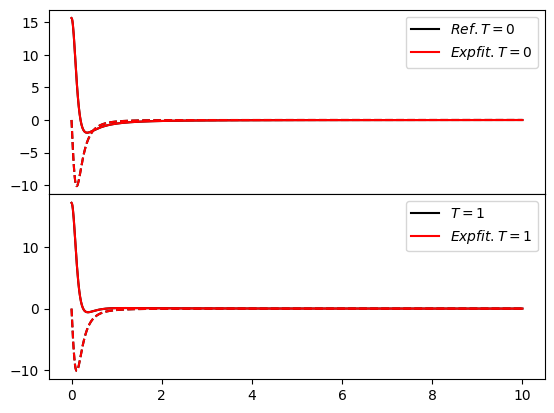

In [ ]:
#specify the number of terms in the sum-of-exponential fit
K=6

#fit the zero and finite temperature baths
dk0, zk0 = bath_zero_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))
dk1, zk1 = bath_finite_T.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

expfit_bath_zero_T = oqs.ExpFitBosonicBath(dk0, zk0)
expfit_bath_finite_T = oqs.ExpFitBosonicBath(dk1, zk1)

Ctd0 = expfit_bath_zero_T.Ct(t)
Ctd1 = expfit_bath_finite_T.Ct(t)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True)
plt.subplots_adjust(hspace=0, wspace=0)

ax[0].set_xlim([0, 2])


#plot the bath correlation functions
Ct0 = bath_zero_T.Ct(t)
ax[0].plot(t, np.real(Ct0), 'k', label=r"$Ref. T=0$")
ax[0].plot(t, np.imag(Ct0), 'k--')
ax[0].plot(t, np.real(Ctd0), 'r', label=r"$Expfit. T=0$")
ax[0].plot(t, np.imag(Ctd0), 'r--')

Ct1 = bath_finite_T.Ct(t)
ax[1].plot(t, np.real(Ct1), 'k', label=r"$T=1$")
ax[1].plot(t, np.imag(Ct1), 'k--')
ax[1].plot(t, np.real(Ctd1), 'r', label=r"$Expfit. T=1$")
ax[1].plot(t, np.imag(Ctd1), 'r--')

ax[0].legend()
ax[1].legend()

plt.show()

Here we observe considerably more efficient reproduction of the bath correlation function, which highlights one of the key advantages of using the non-unitary approaches over unitary approaches for OQS dynamics, namely the typically considerably more compact representation of the influence of the bath on the system for continuous bath spectral densities.